In [1]:
print("aaaa")

aaaa


# Collecte

In [11]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from pandas import json_normalize
import pandas as pd
import json

endpoint_url = "https://query.wikidata.org/sparql"
nb_images= "100"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT """+nb_images


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )
    
dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)
dataframe

with open('./data/data.json', 'w', encoding='utf-8') as f:
    json.dump(array, f, ensure_ascii=False, indent=4)

In [12]:
import requests
import shutil
import os


def download_image(url, destination_path):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(destination_path+os.path.basename(url), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

destination_path = "./images/"
dataframe.image.apply(lambda x: download_image(x, destination_path))

0     200
1     200
2     200
3     200
4     200
     ... 
95    200
96    200
97    200
98    200
99    200
Name: image, Length: 100, dtype: int64

# Couleur prédominante

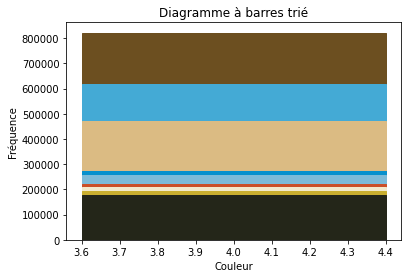

[821239, 618790, 471232, 273613, 273055, 256213, 221768, 208953, 192719, 176012]
[0 1 2 3 4 5 6 7 8 9]
(6, 144, 204)
lightseagreen
(67, 169, 212)
mediumturquoise
(124, 186, 215)
skyblue
(107, 78, 31)
saddlebrown
(35, 37, 24)
black
(218, 186, 130)
burlywood
(201, 174, 47)
goldenrod
(242, 233, 203)
blanchedalmond
(125, 120, 103)
gray
(202, 79, 39)
chocolate


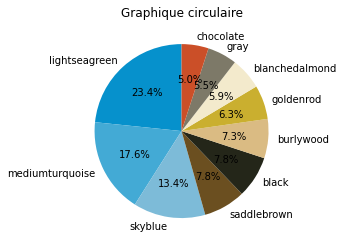

In [43]:
from PIL import Image, ImageColor
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from webcolors import CSS3_HEX_TO_NAMES, CSS3_NAMES_TO_HEX, rgb_to_name, hex_to_rgb, hex_to_name, rgb_to_hex
from colorspacious import cspace_convert

def get_approx_color(hex_color):
    orig = hex_to_rgb(hex_color)
    similarity = {}
    for hex_code, color_name in CSS3_HEX_TO_NAMES.items():
        approx = hex_to_rgb(hex_code)
        similarity[color_name] = sum(numpy.subtract(orig, approx) ** 2)
    return min(similarity, key=similarity.get)
 
def get_color_name(hex_color):
    try:
        return hex_to_name(hex_color)
    except ValueError:
        return get_approx_color(hex_color)


# Demander à l'utilisateur le nombre de clusters et le nom du fichier image
num_clusters = 10
filename = "./images/Saint-Basil-Red-Square.jpg"

# Charger l'image et la convertir en tableau numpy
imgfile = Image.open(filename)
numarray = numpy.array(imgfile.getdata(), numpy.uint8)

# Regrouper les couleurs en clusters
clusters = KMeans(n_clusters=num_clusters, n_init=2)
clusters.fit(numarray)

# Calculer l'histogramme des étiquettes de cluster triées
npbins = numpy.arange(0, num_clusters+1)
histogram, bin_edges = numpy.histogram(clusters.labels_, bins=npbins)
sort_indices = numpy.argsort(histogram)[::-1]
histogram_sorted = histogram[sort_indices]
labels_sorted = clusters.labels_[clusters.labels_ != -1][sort_indices]

# Créer le diagramme à barres trié
barlist = plot.bar(labels_sorted, histogram_sorted)
for i in range(num_clusters):
    barlist[i].set_color(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        ))
plot.title("Diagramme à barres trié")
plot.xlabel("Couleur")
plot.ylabel("Fréquence")
plot.show()

# Créer le graphique circulaire
freqs = [histogram_sorted[i] for i in range(num_clusters)]
colors = [(c[0]/255, c[1]/255, c[2]/255) for c in clusters.cluster_centers_[sort_indices]]
labels = labels = numpy.unique(clusters.labels_)
print(freqs)
print(labels)
labels_final = []

for i in colors:
    r= int(i[0]*255)
    g= int(i[1]*255)
    b= int(i[2]*255)
    print( (r, g, b) , end = '\n')
    
    hex = rgb_to_hex((round(i[0]*255), round(i[1]*255), round(i[2]*255)))
    color_name = get_color_name(hex)

    print(color_name)
    labels_final.append(color_name)

plot.pie(freqs, labels=labels_final, colors=colors, startangle=90, autopct='%1.1f%%')
plot.title("Graphique circulaire")
plot.show()

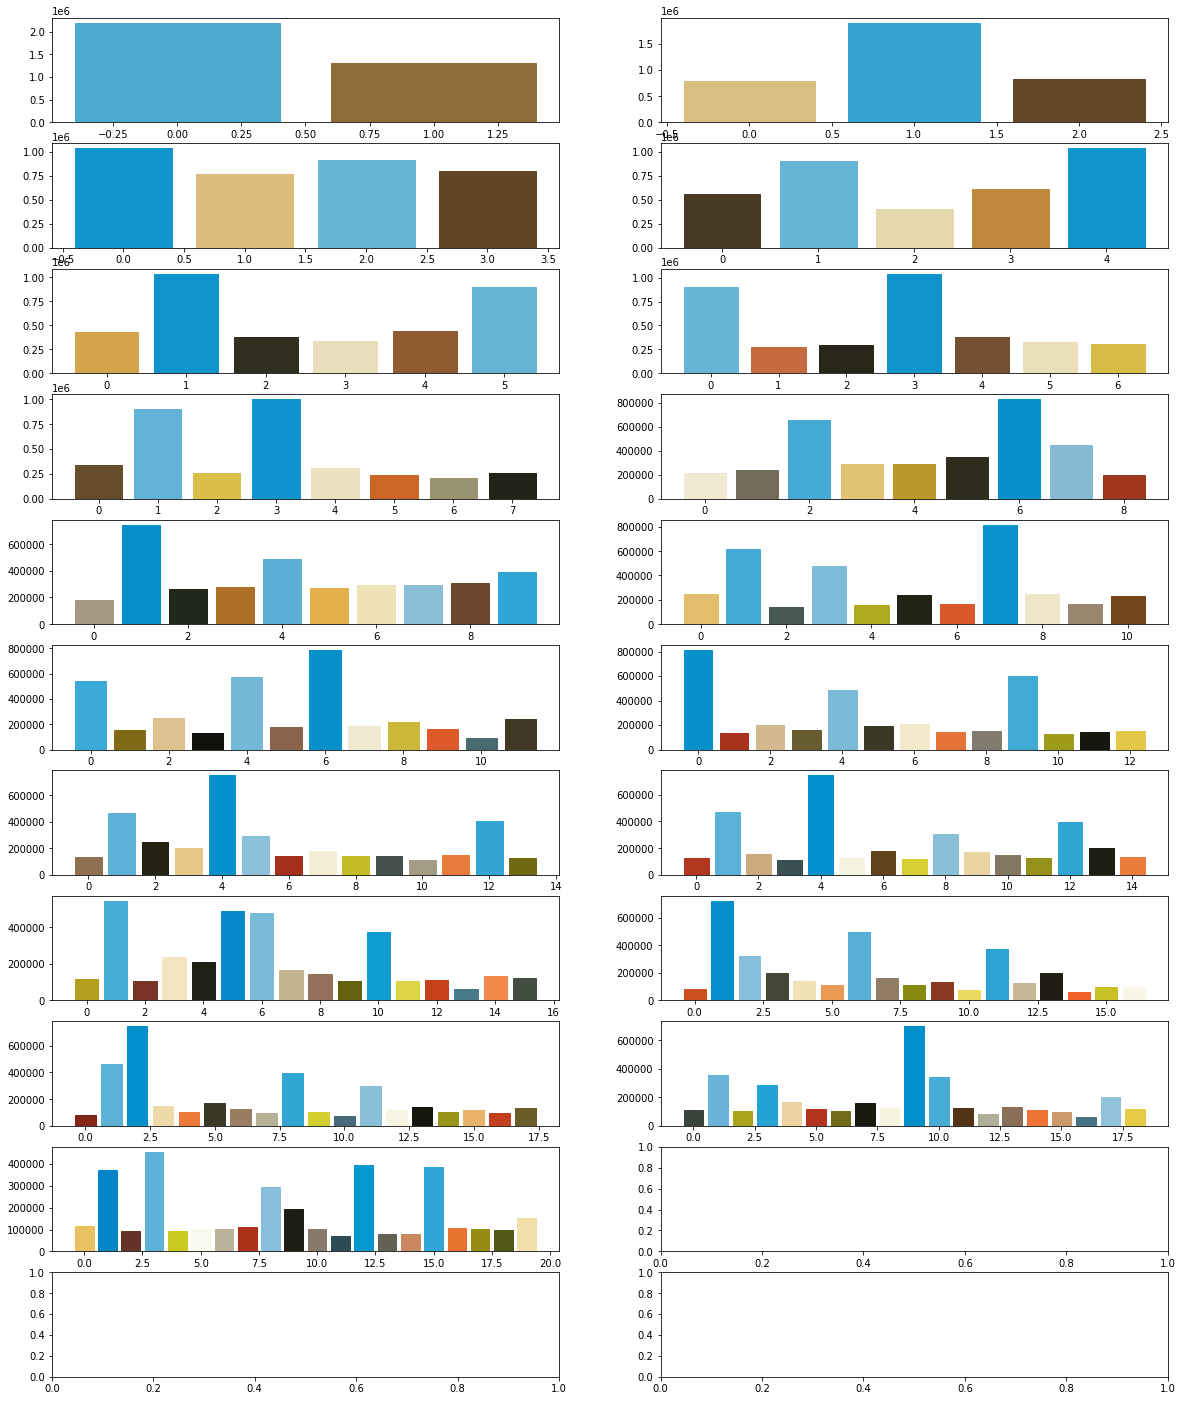

In [8]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import MiniBatchKMeans

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)
X = []
Y = []
fig, axes = plot.subplots(nrows=11, ncols=2, figsize=(20, 25))
xaxis = 0
yaxis = 0
for x in range(2, 21):
    cluster_count = x

    clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
    clusters.fit(numarray)

    npbins = numpy.arange(0, cluster_count + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    barlist = axes[xaxis, yaxis].bar(labels, histogram[0])
    if yaxis == 0:
        yaxis = 1
    else:
        xaxis = xaxis + 1
        yaxis = 0
    for i in range(cluster_count):
        barlist[i].set_color(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )
plot.show()

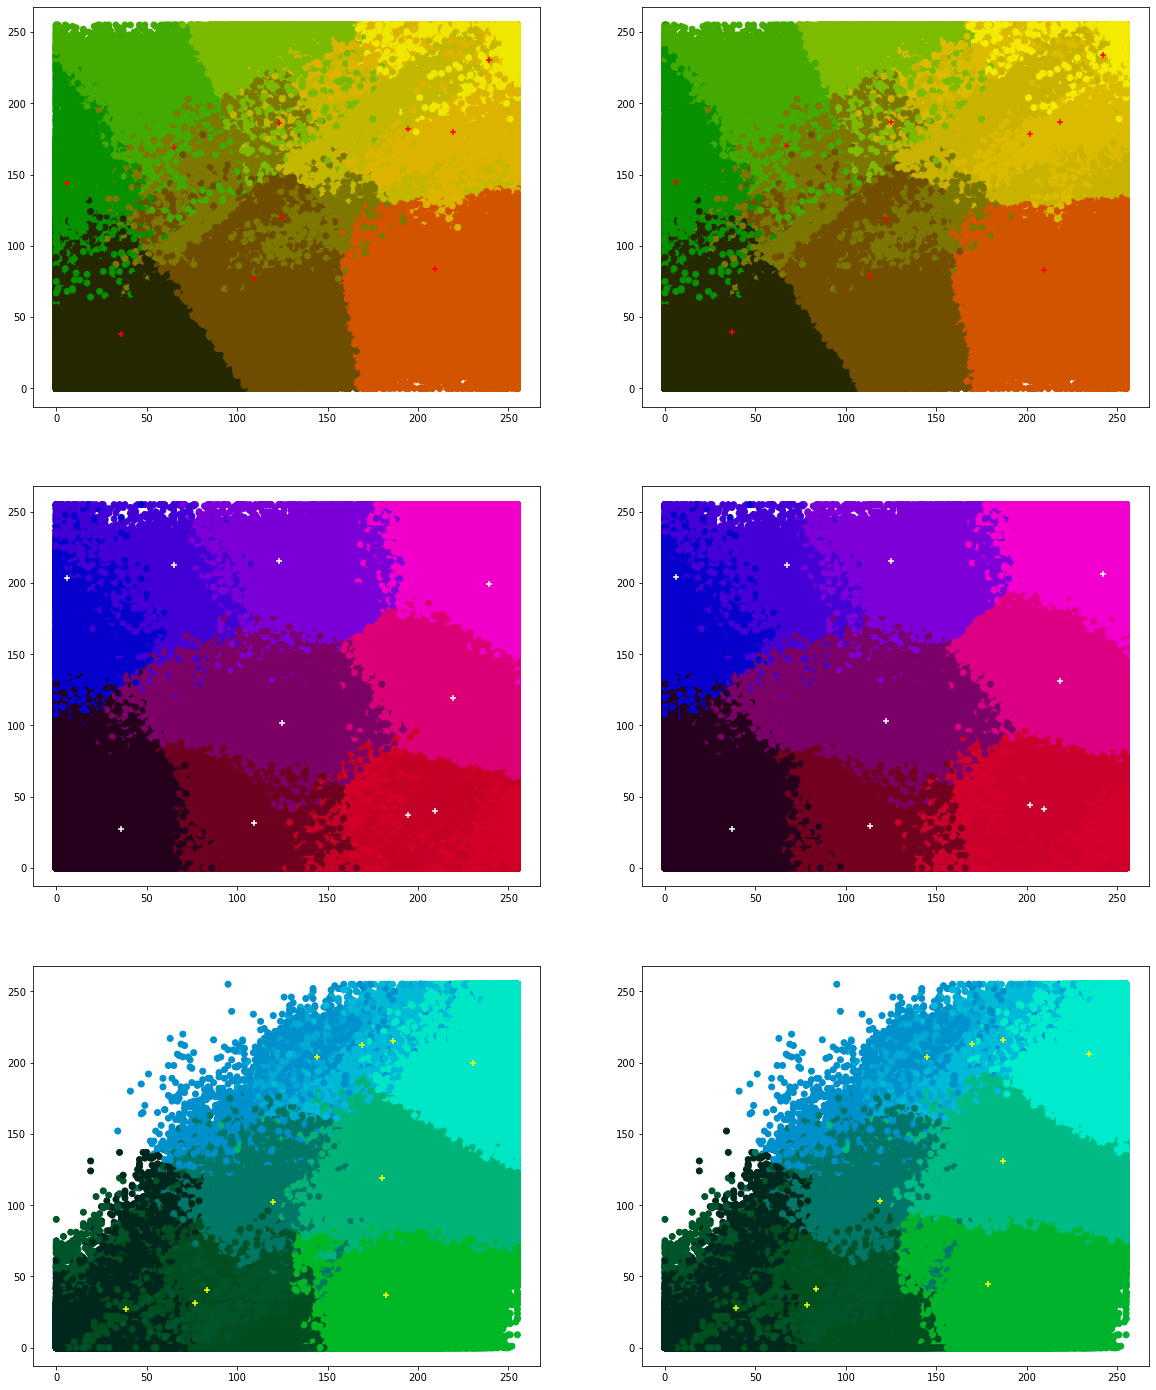

In [6]:
from PIL import Image
import numpy
import math
import time
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)

cluster_count = 10

#MiniBatchKMeans

mclusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
mclusters.fit(numarray)

npbins = numpy.arange(0, cluster_count + 1)
histogram = numpy.histogram(mclusters.labels_, bins=npbins)
labels = numpy.unique(mclusters.labels_)

fig, axes = plot.subplots(nrows=3, ncols=2, figsize=(20, 25))

# Scatter plot for RG (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(mclusters.cluster_centers_[j][0]),
            math.ceil(mclusters.cluster_centers_[j][1]),
            0,
        )
    )

axes[0, 0].scatter(numarray[:, 0], numarray[:, 1], c=colors)
axes[0, 0].scatter(
    mclusters.cluster_centers_[:, 0],
    mclusters.cluster_centers_[:, 1],
    marker="+",
    c="red",
)

# Scatter plot for RB (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(mclusters.cluster_centers_[j][0]),
            0,
            math.ceil(mclusters.cluster_centers_[j][2]),
        )
    )

axes[1, 0].scatter(numarray[:, 0], numarray[:, 2], c=colors)
axes[1, 0].scatter(
    mclusters.cluster_centers_[:, 0],
    mclusters.cluster_centers_[:, 2],
    marker="+",
    c="white",
)

# Scatter plot for GB (RGB)
colors = []
for i in range(len(numarray)):
    j = mclusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            0,
            math.ceil(mclusters.cluster_centers_[j][1]),
            math.ceil(mclusters.cluster_centers_[j][2]),
        )
    )

axes[2, 0].scatter(numarray[:, 1], numarray[:, 2], c=colors)
axes[2, 0].scatter(
    mclusters.cluster_centers_[:, 1],
    mclusters.cluster_centers_[:, 2],
    marker="+",
    c="yellow",
)

#KMeans
clusters = KMeans(n_clusters=cluster_count, n_init=2)
clusters.fit(numarray)

npbins = numpy.arange(0, cluster_count + 1)
histogram = numpy.histogram(clusters.labels_, bins=npbins)
labels = numpy.unique(clusters.labels_)

# Scatter plot for RG (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[j][0]),
            math.ceil(clusters.cluster_centers_[j][1]),
            0,
        )
    )

axes[0, 1].scatter(numarray[:, 0], numarray[:, 1], c=colors)
axes[0, 1].scatter(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 1],
    marker="+",
    c="red",
)

# Scatter plot for RB (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[j][0]),
            0,
            math.ceil(clusters.cluster_centers_[j][2]),
        )
    )

axes[1, 1].scatter(numarray[:, 0], numarray[:, 2], c=colors)
axes[1, 1].scatter(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 2],
    marker="+",
    c="white",
)

# Scatter plot for GB (RGB)
colors = []
for i in range(len(numarray)):
    j = clusters.labels_[i]
    colors.append(
        "#%02x%02x%02x"
        % (
            0,
            math.ceil(clusters.cluster_centers_[j][1]),
            math.ceil(clusters.cluster_centers_[j][2]),
        )
    )

axes[2, 1].scatter(numarray[:, 1], numarray[:, 2], c=colors)
axes[2, 1].scatter(
    clusters.cluster_centers_[:, 1],
    clusters.cluster_centers_[:, 2],
    marker="+",
    c="yellow",
)
plot.show()

Visualisation de la distribution des pixels de l'image dans l'espace de couleurs RGB, en mettant en évidence les clusters trouvés. Les graphiques sont créés pour les combinaisons de couleurs rouge-vert (RG), rouge-bleu (RB), et vert-bleu (GB) pour les clusters trouvés à la fois par MiniBatchKMeans (à gauche) et KMeans (à droite).

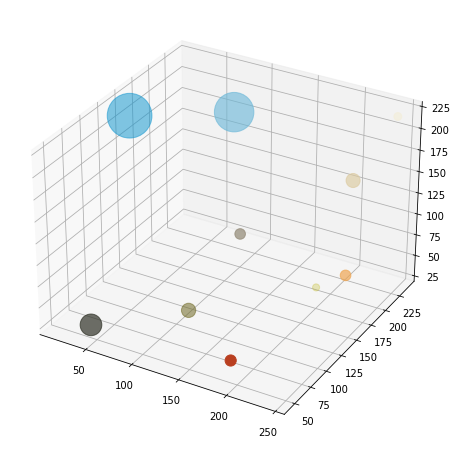

In [7]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import scale, minmax_scale

cluster_count = 10

imgfile = Image.open("./images/Saint-Basil-Red-Square.jpg")
numarray = numpy.array(imgfile.getdata(), numpy.uint8)

# Calculer les clusters
clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
clusters.fit(numarray)


# Calculer le nombre de pixels appartenant à chaque cluster
unique, frequency = numpy.unique(clusters.labels_, return_counts=True)

# Mise à l'échelle de la valeur de la fréquence entre 50 et 2000
# (ces valeurs ont été choisies au hasard)
scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

colors = []
for i in range(len(clusters.cluster_centers_)):
    colors.append(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
    )

# Diagramme de dispersion 3D
plot.figure(figsize=(8, 8))
axes = plot.axes(projection="3d")
axes.scatter3D(
    clusters.cluster_centers_[:, 0],
    clusters.cluster_centers_[:, 1],
    clusters.cluster_centers_[:, 2],
    c=colors,
    s=scaled_frequency,
)

Diagramme de dispersion 3D:
Les centres de cluster sont affichés dans les axes x, y et z du diagramme, la couleur de chaque point représente la couleur moyenne des pixels dans le cluster, et la taille de chaque point représente le nombre de pixels dans le cluster.